In [1]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "static" / "data"

In [2]:
import geopandas
import numpy
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Load the accessibility grid and remove -1 values
accessibility_grid = geopandas.read_file(
    DATA_DIRECTORY
    / "helsinki_region_travel_times_to_railway_station"
    / "helsinki_region_travel_times_to_railway_station.gpkg"
)
accessibility_grid["pt_r_t"] = accessibility_grid["pt_r_t"].replace(-1, numpy.nan)

# Construct the base URL to retrive the Helsinki Metro data
WFS_BASE_URL = (
    "https://kartta.hel.fi/ws/geoserver/avoindata/wfs"
    "?service=wfs"
    "&version=2.0.0"
    "&request=GetFeature"
    "&srsName=EPSG:3879"
    "&typeName={layer:s}"
)

# Read the metro/road data and apply the CRS
metro = (
    geopandas.read_file(
        WFS_BASE_URL.format(layer="avoindata:Seutukartta_liikenne_metro_rata")
    )
    .set_crs("EPSG:3879")
)
roads = (
    geopandas.read_file(
        WFS_BASE_URL.format(layer="avoindata:Seutukartta_liikenne_paatiet")
    )
    .set_crs("EPSG:3879")
)

In [3]:
# Check the CRS
assert accessibility_grid.crs == metro.crs == roads.crs, "Input data sets’ CRS differs"

AssertionError: Input data sets’ CRS differs

In [4]:
# Convert the metro CRS to the accessibility CRS
roads = roads.to_crs(accessibility_grid.crs)
metro = metro.to_crs(accessibility_grid.crs)

Remember the following options that can be passed to plot():

style the polygon layer:

define a classification scheme using the scheme parameter

change the colour map using cmap

control the layer’s transparency the alpha parameter (0 is fully transparent, 1 fully opaque)

style the line layers:

adjust the line colour using the color parameter

change the linewidth, as needed

The layers have different extents (roads covers a much larger area). You can use the axes’ (ax) methods set_xlim() and set_ylim() to set the horizontal and vertical extents of the map (e.g., to a geo-data frame’s total_bounds).

(6665250.00004393, 6698000.000038021)

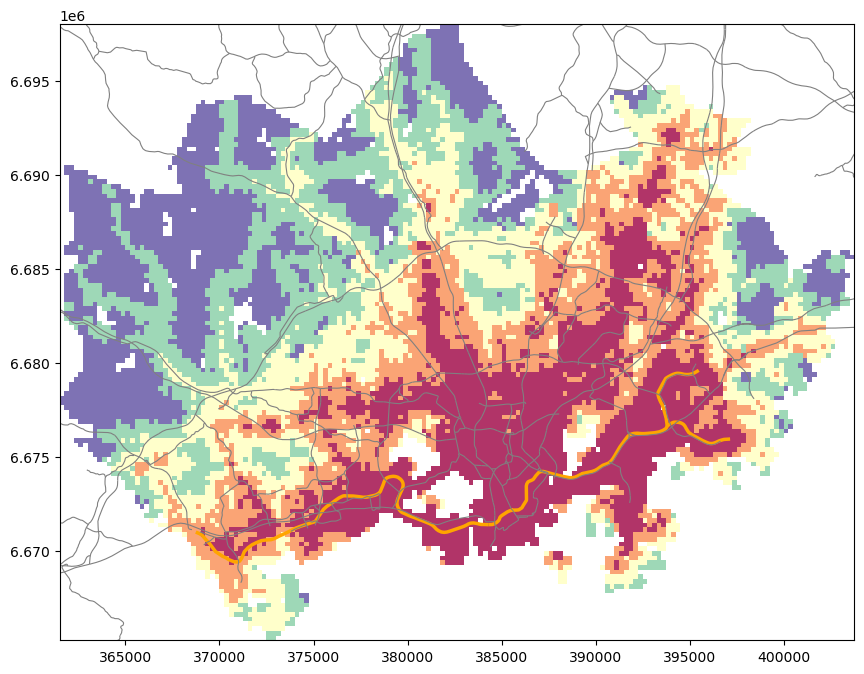

In [5]:
# Plot the public transport times by quantile
ax = accessibility_grid.plot(
    figsize=(12, 8),

    column="pt_r_t",
    scheme="quantiles",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8
)

# Add the metro lines
metro.plot(
    ax=ax,
    color="orange",
    linewidth=2.5
)

# Add the roads
roads.plot(
    ax=ax,
    color="grey",
    linewidth=0.8
)

# Set the map bounds
minx, miny, maxx, maxy = accessibility_grid.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

To plot a legend for a map, add the legend=True parameter.

For figures without a classification scheme, the legend consists of a colour gradient bar. The legend is an instance of matplotlib.pyplot.colorbar.Colorbar, and all arguments defined in legend_kwds are passed through to it. See below how to use the label property to set the legend title:

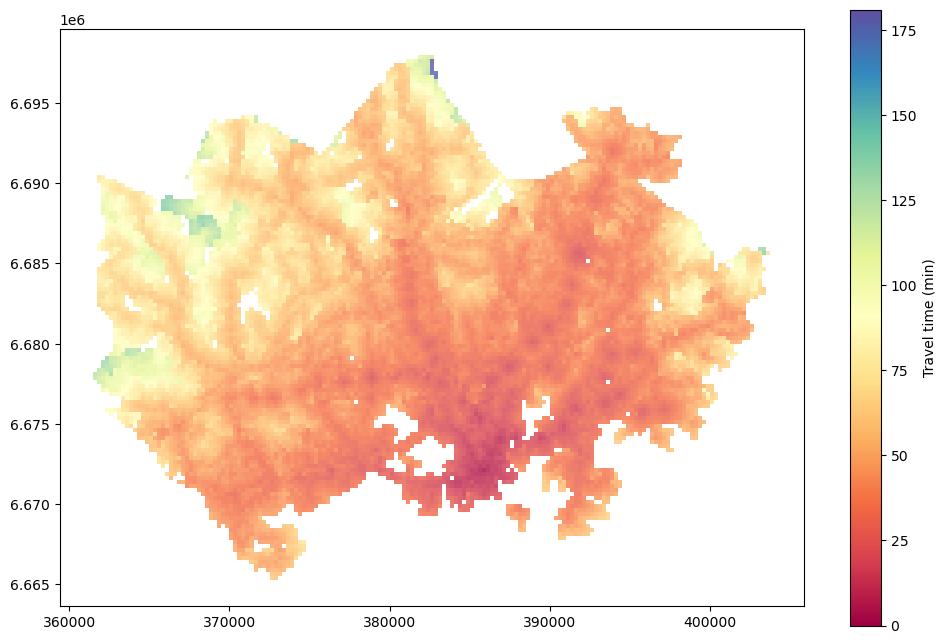

In [6]:
ax = accessibility_grid.plot(
    figsize=(12, 8),

    column="pt_r_t",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"label": "Travel time (min)"}
)

For figures that use a classification scheme, on the other hand, plot() creates a matplotlib.legend.Legend. Again, legend_kwds are passed through, but the parameters are slightly different: for instance, use title instead of label to set the legend title:

<AxesSubplot: >

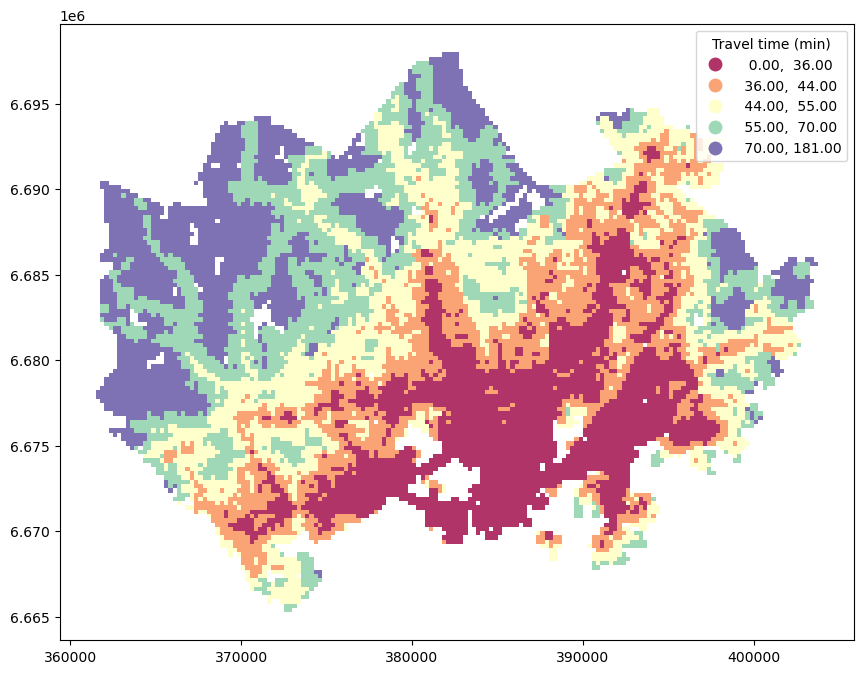

In [7]:
accessibility_grid.plot(
    figsize=(12, 8),

    column="pt_r_t",
    scheme="quantiles",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"title": "Travel time (min)"}
)

For better orientation, it is often helpful to add a base map to a map plot. A base map, for instance, from map providers such as OpenStreetMap or Stamen, adds streets, place names, and other contextual information.

The Python package contextily takes care of downloading the necessary map tiles and rendering them in a geopandas plot.

Map tiles from online map providers are typically in Web Mercator projection (EPSG:3857. It is generally advisable to transform all other layers to EPSG:3857, too.

In [8]:
accessibility_grid = accessibility_grid.to_crs("EPSG:3857")
metro = metro.to_crs("EPSG:3857")
roads = roads.to_crs("EPSG:3857")

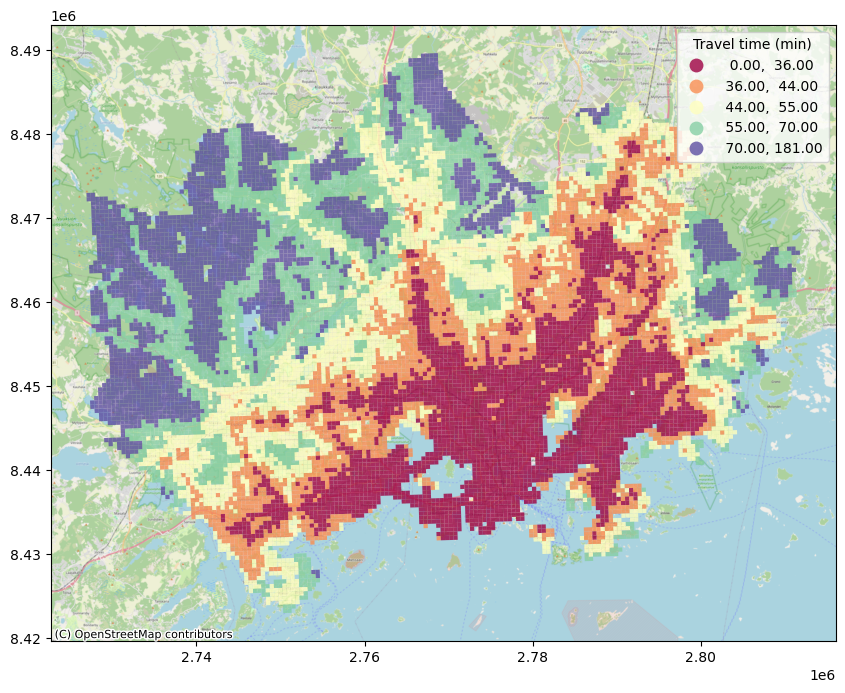

In [9]:
import contextily

ax = accessibility_grid.plot(
    figsize=(12, 8),

    column="pt_r_t",
    scheme="quantiles",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"title": "Travel time (min)"}
)
contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik)

In this zoom level, the benefits from using OpenStreetMap (such as place names) do not live to their full potential. Let’s look at a subset of the travel time matrix: grid cells that are within 15 minutes from the railway station.

In [ ]:
# see the other map providers from contextily
contextily.providers

In [ ]:
ax = accessibility_grid[accessibility_grid.pt_r_t <= 15].plot(
    figsize=(12, 8),

    column="pt_r_t",
    scheme="quantiles",
    k=5,
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"title": "Travel time (min)"}
)
contextily.add_basemap(
    ax,
    source=contextily.providers.OpenStreetMap.Mapnik
)

In [ ]:
# Change the copyright information on the map
ax = accessibility_grid[accessibility_grid.pt_r_t <= 15].plot(
    figsize=(12, 8),

    column="pt_r_t",
    scheme="quantiles",
    k=5,
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"title": "Travel time (min)"}
)
contextily.add_basemap(
    ax,
    source=contextily.providers.OpenStreetMap.Mapnik,
    attribution=(
        "Travel time data (c) Digital Geography Lab, "
        "map data (c) OpenStreetMap contributors"
    )
)